In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
sns.set_style('whitegrid')
from tqdm.auto import tqdm, trange

# Functions

In [ ]:
# Get homology representatives (cycles) based on list of connected edges
def get_cycles(cycles):

    new_cycle_flag = True
    cycles_list = []
    cur_cycle = set()

    for a, b in cycles:
        if new_cycle_flag:
            cur_cycle.update([a])
            cur_cycle.update([b])
            cycles_list.append([])
            new_cycle_flag = False
            continue

        if a in cur_cycle:
            cur_cycle.remove(a)
            cycles_list[-1].append(a)
        else:
            cur_cycle.update([a])

        if b in cur_cycle:
            cur_cycle.remove(b)
            cycles_list[-1].append(b)
        else:
            cur_cycle.update([b])

        if len(cur_cycle) == 0:
            new_cycle_flag = True

    return cycles_list

In [ ]:
# Get hole_contours for each space part
def get_holes_per_chunk(dir="holes/", filenames="ru_word_holes_norm_*.npy"):

  hole_contours = {}

  for file in glob.glob(f"{dir}/{filenames}"):
        hole_contours["_".join(file.split('_')[4:])[:-4]] = get_cycles(np.load(file) - 1) # !attention to filenames!

  return hole_contours

In [ ]:
def get_homology_birth_death(files):
    h_bd = {}

    for fn in files:
        chunk_num = "_".join(fn.split('_')[2:])[:-4] # !attention to filenames!
        h_bd[chunk_num] = np.load(fn)

    h_all = np.hstack(list(h_bd.values()))
    h_lifetimes = np.diff(h_all, axis=0)

    return h_all, h_lifetimes, h_bd

In [ ]:
# Merge all homologies from different chunks and plot diagram
def collect_holes_from_chunks(dir="holes/"):

    h0_all, h0_lifetimes, h0_bd = get_homology_birth_death(glob.glob(f"{dir}/h0_norm_*.npy"))
    h1_all, h1_lifetimes, h1_bd = get_homology_birth_death(glob.glob(f"{dir}/h1_norm_*.npy"))

    plt.figure(figsize=(10, 8))

    # lifetimes
    h0_lifetime = h0_all[1] - h0_all[0]
    h1_lifetime = h1_all[1] - h1_all[0]

    sc0 = plt.scatter(h0_all[0], h0_all[1], s=10, alpha=0.5, c=h0_lifetime, cmap='viridis', marker='s', label='$H_0$')
    sc1 = plt.scatter(h1_all[0], h1_all[1], s=10, alpha=0.5, c=h1_lifetime, cmap='viridis', marker='o', label='$H_1$')

    # Colorbar for both
    plt.colorbar(sc1, label='lifetime')

    # Diagonal for h1
    plt.plot([h1_all[0].min(), h1_all[1].max()],
             [h1_all[0].min(), h1_all[1].max()],
             'r--', linewidth=2, alpha=0.8, label='$H_1$ birth=death')

    plt.xlabel('birth')
    plt.ylabel('death')
    plt.title('Persistence diagram ($H_0$ and $H_1$)')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

    return (h0_all, h0_lifetimes, h0_bd), (h1_all, h1_lifetimes, h1_bd)

In [ ]:
from scipy.spatial.distance import pdist, squareform

# Get hole diameters using files from space partition
def get_hole_diam(filtered_by_lifetime, h1_contours, lang='ru', part='word'):
    hole_diam = {}

    for n_chunk in tqdm(filtered_by_lifetime):
        if filtered_by_lifetime[n_chunk] == -1: continue
        hole_diam[n_chunk] = []
        chunk_emb = np.load(f'partition/{lang}_{part}_norm_{n_chunk}.npy')
        chunk_pdist = squareform(pdist(chunk_emb, metric='cosine'))
        cycles_list = h1_contours[n_chunk][filtered_by_lifetime[n_chunk]:] # list of cycles of holes, filtered by lifetime (in one chunk)

        for edges in cycles_list:
            hole_diam[n_chunk].append(chunk_pdist[edges][:,edges].max())
    return hole_diam

In [ ]:
# Save first indices beginning from which holes are more persistent
def filter_by_lifetimes(h1_lifetimes, h1_bd, h1_contours, q=.99):
    q = np.quantile(h1_lifetimes, q=.99)
    filtered_by_lifetime = {}

    for n_chunk in h1_bd:
        if n_chunk not in h1_contours: continue

        chunk_n_holes = len(h1_contours[n_chunk])
        idx = np.where(np.diff(h1_bd[n_chunk], axis=0)[0][-chunk_n_holes:] > q)[0]
        filtered_by_lifetime[n_chunk] = idx[0] if len(idx) else -1

    return filtered_by_lifetime

In [ ]:
# save first indices beginning from which holes are more persistent
def filter_by_hole_diam(hole_diam, filtered_by_lifetime, q=.99):
    q_ = np.quantile(np.hstack(list(hole_diam.values())), q=q)
    filtered_by_hole_diam = {}

    for n_chunk in hole_diam:
        idx = np.where(hole_diam[n_chunk] > q_)[0]

        if len(idx):
            filtered_by_hole_diam[n_chunk] = idx + filtered_by_lifetime[n_chunk]

    return filtered_by_hole_diam

In [ ]:
def words_on_contour(filtered_holes, words, word_partition):
  for c in filtered_holes:
    cluster_idx = np.where(word_partition == c)[0]
    print(f"\nCluster {c}:")
    print('*' * 20)

    # Skip if no words in this cluster
    if len(cluster_idx) == 0:
        print(f"No words found in cluster {c}")
        continue

    for hole_num in filtered_holes[c]:
        try:
            # Contour indices (may be a list)
            contour_indices = h1_contours[c][hole_num]

            # Both single index and list cases
            if isinstance(contour_indices, (list, np.ndarray)):
                words_in_hole = []
                for idx in contour_indices:
                    if 0 <= idx < len(cluster_idx):
                        word = words[cluster_idx[idx]]
                        words_in_hole.append(word.tolist() if hasattr(word, 'tolist') else word)
                    else:
                        print(f"Index {idx} out of bounds for cluster {c}")
                print(f"Hole {hole_num}: {words_in_hole}")
            else:
                # Single index case
                if 0 <= contour_indices < len(cluster_idx):
                    word = words[cluster_idx[contour_indices]]
                    print(f"Hole {hole_num}: {word.tolist() if hasattr(word, 'tolist') else word}")
                else:
                    print(f"Index {contour_indices} out of bounds for cluster {c}")

        except Exception as e:
            print(f"Error processing hole {hole_num} in cluster {c}: {str(e)}")

# Ru bigrams

## Collect holes

In [ ]:
# For all chunks get hole contours from hole indices
h1_contours = get_holes_per_chunk("holes/", "ru_bigram_holes_norm_*.npy")

In [ ]:
print([(cn, len(h1_contours[cn]))for cn in h1_contours])

[('3b', 500), ('3a', 500), ('4b', 500), ('4a', 500), ('1', 500), ('7', 500), ('5b', 500), ('5a', 500), ('8a', 500), ('6', 500), ('2', 500), ('0', 500), ('9', 500), ('8b', 500)]


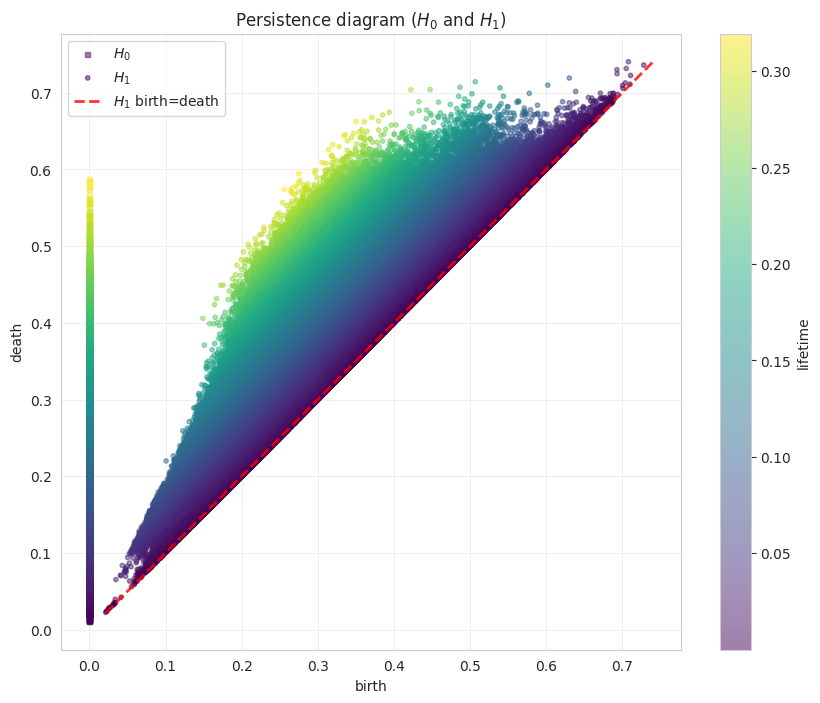

In [ ]:
# For all chunks get features and plot the persistence diagram
(h0_all, h0_lifetimes, h0_bd), (h1_all, h1_lifetimes, h1_bd) = collect_holes_from_chunks("holes/")

In [ ]:
h0_all.shape, h1_all.shape

((2, 135859), (2, 278028))

## Filter by lifetime

In [ ]:
filtered_by_lifetime = filter_by_lifetimes(h1_lifetimes, h1_bd, h1_contours)
np.save("holes/ru_bigram_filtered_by_lifetimes.npy", filtered_by_lifetime)
filtered_by_lifetime

{'2': np.int64(226),
 '5a': np.int64(178),
 '6': np.int64(475),
 '4b': np.int64(493),
 '1': np.int64(499),
 '5b': np.int64(447),
 '8b': np.int64(0),
 '7': np.int64(244),
 '3a': np.int64(99),
 '0': np.int64(114),
 '4a': np.int64(474),
 '9': np.int64(190),
 '3b': np.int64(498),
 '8a': np.int64(475)}

In [ ]:
sum(v for v in filtered_by_lifetime.values() if v not in {-1, 0})

np.int64(4412)

## Filter by hole diameter

In [ ]:
hole_diam = get_hole_diam(filtered_by_lifetime, h1_contours, lang='ru', part='bigram')
np.save("holes/ru_bigram_hole_diams.npy", hole_diam)

  0%|          | 0/14 [00:00<?, ?it/s]

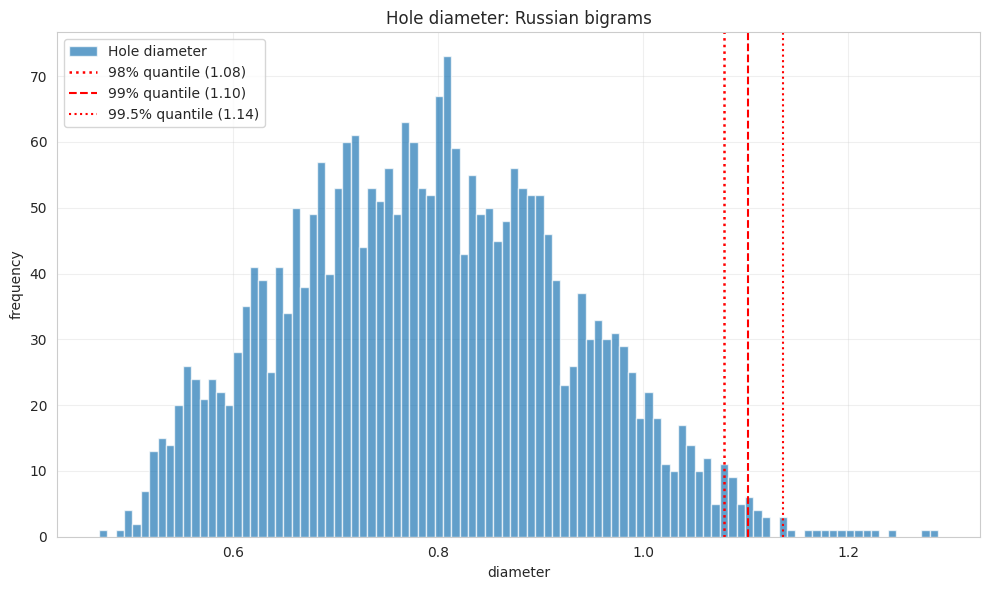

In [ ]:
# Diameters distribution
plt.figure(figsize=(10, 6))

diameters = np.hstack(list(hole_diam.values()))
q98 = np.quantile(diameters, 0.98)
q99 = np.quantile(diameters, 0.99)
q995 = np.quantile(diameters, 0.995)

plt.hist(diameters, bins=100, alpha=0.7, label='Hole diameter')

# Quantile lines
plt.axvline(q98, color='r', linestyle=':', linewidth=1.8, label=f'98% quantile ({q98:.2f})')
plt.axvline(q99, color='r', linestyle='--', linewidth=1.5, label=f'99% quantile ({q99:.2f})')
plt.axvline(q995, color='r', linestyle=':', linewidth=1.5, label=f'99.5% quantile ({q995:.2f})')

plt.xlabel('diameter')
plt.ylabel('frequency')
plt.title('Hole diameter: Russian bigrams')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
filtered_by_hole_diam_98 = filter_by_hole_diam(hole_diam, filtered_by_lifetime, q=.98)
np.save("holes/ru_bigram_filtered_by_lifetimes_diam_98.npy", filtered_by_hole_diam_98)
filtered_by_hole_diam_98

{'2': array([278, 348, 363, 434, 447, 454, 467, 474]),
 '5a': array([295, 425, 430]),
 '8b': array([ 60, 208, 262, 295, 296, 337, 352, 353, 358, 372, 412, 415, 418,
        426, 440, 448, 467, 476, 477, 480, 487, 492]),
 '7': array([362, 370, 450, 455, 475, 498]),
 '3a': array([188, 277, 299, 454]),
 '0': array([336, 399, 443, 463, 491]),
 '9': array([441, 473, 476, 484])}

In [ ]:
sum(len(arr) for arr in filtered_by_hole_diam_98.values())

52

In [ ]:
filtered_by_hole_diam_99 = filter_by_hole_diam(hole_diam, filtered_by_lifetime, q=.99)
np.save("holes/ru_bigram_filtered_by_lifetimes_diam_99.npy", filtered_by_hole_diam_99)
filtered_by_hole_diam_99

{'2': array([278, 363, 434, 454, 467]),
 '8b': array([ 60, 296, 337, 412, 418, 426, 448, 477, 487, 492]),
 '7': array([362, 450, 455, 475, 498]),
 '3a': array([299, 454]),
 '0': array([336, 399, 491]),
 '9': array([441])}

In [ ]:
sum(len(arr) for arr in filtered_by_hole_diam_99.values())

26

In [ ]:
filtered_by_hole_diam_995 = filter_by_hole_diam(hole_diam, filtered_by_lifetime, q=.995)
np.save("holes/ru_bigram_filtered_by_lifetimes_diam_995.npy", filtered_by_hole_diam_995)
filtered_by_hole_diam_995

{'2': array([363, 467]),
 '8b': array([ 60, 412, 418, 477, 487, 492]),
 '7': array([362, 475]),
 '0': array([336, 399, 491])}

In [ ]:
sum(len(arr) for arr in filtered_by_hole_diam_995.values())

13

In [ ]:
!ls holes

h0_norm_0.npy	h1_norm_7.npy
h0_norm_1.npy	h1_norm_8a.npy
h0_norm_2.npy	h1_norm_8b.npy
h0_norm_3a.npy	h1_norm_9.npy
h0_norm_3b.npy	ru_bigram_filtered_by_lifetimes_diam_98.npy
h0_norm_4a.npy	ru_bigram_filtered_by_lifetimes_diam_995.npy
h0_norm_4b.npy	ru_bigram_filtered_by_lifetimes_diam_99.npy
h0_norm_5a.npy	ru_bigram_filtered_by_lifetimes.npy
h0_norm_5b.npy	ru_bigram_hole_diams.npy
h0_norm_6.npy	ru_bigram_holes_norm_0.npy
h0_norm_7.npy	ru_bigram_holes_norm_1.npy
h0_norm_8a.npy	ru_bigram_holes_norm_2.npy
h0_norm_8b.npy	ru_bigram_holes_norm_3a.npy
h0_norm_9.npy	ru_bigram_holes_norm_3b.npy
h1_norm_0.npy	ru_bigram_holes_norm_4a.npy
h1_norm_1.npy	ru_bigram_holes_norm_4b.npy
h1_norm_2.npy	ru_bigram_holes_norm_5a.npy
h1_norm_3a.npy	ru_bigram_holes_norm_5b.npy
h1_norm_3b.npy	ru_bigram_holes_norm_6.npy
h1_norm_4a.npy	ru_bigram_holes_norm_7.npy
h1_norm_4b.npy	ru_bigram_holes_norm_8a.npy
h1_norm_5a.npy	ru_bigram_holes_norm_8b.npy
h1_norm_5b.npy	ru_bigram_holes_norm_9.npy
h1_norm_6.npy


## Hole contours in words

In [ ]:
word_dictionary = np.load("ru_bigram_norm_dictionary.npy", allow_pickle=True).item()
words = list(word_dictionary.keys())
word_partition = np.load('partition/ru_bigram_partition_norm.npy')

In [ ]:
words_on_contour(filtered_by_hole_diam_98, words, word_partition)


Cluster 2:
********************
Hole 278: ['смерть девушка', 'судьба девушка', 'жизнь девушка', 'жизнь юноша', 'жизнь старец', 'жизнь господь', 'жизнь царь', 'жизнь король', 'жизнь супруг', 'жизнь жена', 'жизнь ребенок', 'судьба ребенок', 'смерть ребенок', 'умирать ребенок', 'родить ребенок', 'родить девочка', 'пятнадцатилетний девочка', 'черноглазый девочка', 'черноглазый девушка', 'семнадцатилетний девушка', 'наивный девушка', 'глупый девушка', 'глупый женщина', 'распутный женщина', 'бедный женщина', 'несчастный девушка', 'бедный девушка']
Hole 348: ['чужой мужик', 'чужой баба', 'чужой деньга', 'мирской деньга', 'народ деньга', 'народ крестьянин', 'народ человек', 'грабить человек', 'чужой мужчина', 'чужой человек']
Hole 363: ['молодой офицерик', 'молодой франт', 'молодой барышня', 'молоденький барышня', 'хорошенький барышня', 'милый барышня', 'милый маменька', 'милый мамаша', 'милый девочка', 'хорошенький девочка', 'семнадцатилетний девочка', 'пятнадцатилетний девочка', 'младший де

In [ ]:
words_on_contour(filtered_by_hole_diam_99, words, word_partition)


Cluster 2:
********************
Hole 278: ['смерть девушка', 'судьба девушка', 'жизнь девушка', 'жизнь юноша', 'жизнь старец', 'жизнь господь', 'жизнь царь', 'жизнь король', 'жизнь супруг', 'жизнь жена', 'жизнь ребенок', 'судьба ребенок', 'смерть ребенок', 'умирать ребенок', 'родить ребенок', 'родить девочка', 'пятнадцатилетний девочка', 'черноглазый девочка', 'черноглазый девушка', 'семнадцатилетний девушка', 'наивный девушка', 'глупый девушка', 'глупый женщина', 'распутный женщина', 'бедный женщина', 'несчастный девушка', 'бедный девушка']
Hole 363: ['молодой офицерик', 'молодой франт', 'молодой барышня', 'молоденький барышня', 'хорошенький барышня', 'милый барышня', 'милый маменька', 'милый мамаша', 'милый девочка', 'хорошенький девочка', 'семнадцатилетний девочка', 'пятнадцатилетний девочка', 'младший девочка', 'младший сестренка', 'младший брат', 'троюродный брат', 'троюродный дядя', 'покойный дядя', 'покойный тетушка', 'покойный матушка', 'покойный княгиня', 'покойный князь', 'п

In [ ]:
words_on_contour(filtered_by_hole_diam_995, words, word_partition)


Cluster 2:
********************
Hole 363: ['молодой офицерик', 'молодой франт', 'молодой барышня', 'молоденький барышня', 'хорошенький барышня', 'милый барышня', 'милый маменька', 'милый мамаша', 'милый девочка', 'хорошенький девочка', 'семнадцатилетний девочка', 'пятнадцатилетний девочка', 'младший девочка', 'младший сестренка', 'младший брат', 'троюродный брат', 'троюродный дядя', 'покойный дядя', 'покойный тетушка', 'покойный матушка', 'покойный княгиня', 'покойный князь', 'племянник князь', 'княгиня князь', 'князь князь', 'посол князь', 'господин князь', 'господин барон', 'господин фельдмаршал', 'господин генерал', 'генерал генерал', 'жандармский генерал', 'отставной генерал', 'штатский генерал', 'штатский господин', 'щеголеватый господин', 'пожилой господин', 'молодой господин', 'молодой полковник', 'молодой поручик']
Hole 467: ['жаль молодой', 'милый молодой', 'благовоспитанный молодой', 'молодой молодой', 'молодой белокурый', 'молодой пригожий', 'молодой боярыня', 'молодой княз

# Slv bigrams

## Collect holes

In [ ]:
# For all chunks get hole contours from hole indices
h1_contours = get_holes_per_chunk("holes/", "slv_bigram_holes_norm_*.npy")

In [ ]:
print([(cn, len(h1_contours[cn]))for cn in h1_contours])

[('6b', 500), ('6a', 500), ('2', 500), ('5a', 500), ('7', 500), ('9b', 500), ('0', 500), ('4', 500), ('5b', 500), ('9a', 500), ('8', 500), ('3', 500), ('1', 500)]


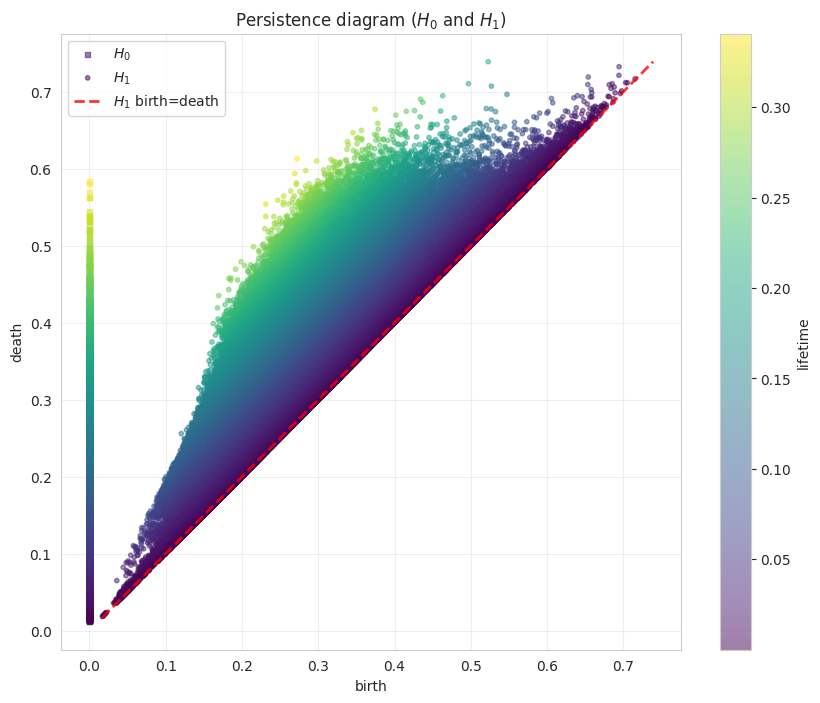

In [ ]:
# For all chunks get features and plot the persistence diagram
(h0_all, h0_lifetimes, h0_bd), (h1_all, h1_lifetimes, h1_bd) = collect_holes_from_chunks("holes/")

In [ ]:
h0_all.shape, h1_all.shape

((2, 147632), (2, 312266))

## Filter by lifetime

In [ ]:
filtered_by_lifetime = filter_by_lifetimes(h1_lifetimes, h1_bd, h1_contours)
np.save("holes/slv_bigram_filtered_by_lifetimes.npy", filtered_by_lifetime)
filtered_by_lifetime

{'6b': np.int64(412),
 '5a': np.int64(389),
 '4': np.int64(0),
 '9a': np.int64(461),
 '9b': np.int64(0),
 '1': np.int64(345),
 '5b': np.int64(120),
 '7': np.int64(224),
 '3': -1,
 '6a': np.int64(268),
 '8': -1,
 '0': np.int64(0)}

In [ ]:
sum(v for v in filtered_by_lifetime.values() if v not in {-1, 0})

np.int64(2219)

## Filter by hole diameter

In [ ]:
hole_diam = get_hole_diam(filtered_by_lifetime, h1_contours, lang='slv', part='bigram')
np.save("holes/slv_bigram_hole_diams.npy", hole_diam)

  0%|          | 0/12 [00:00<?, ?it/s]

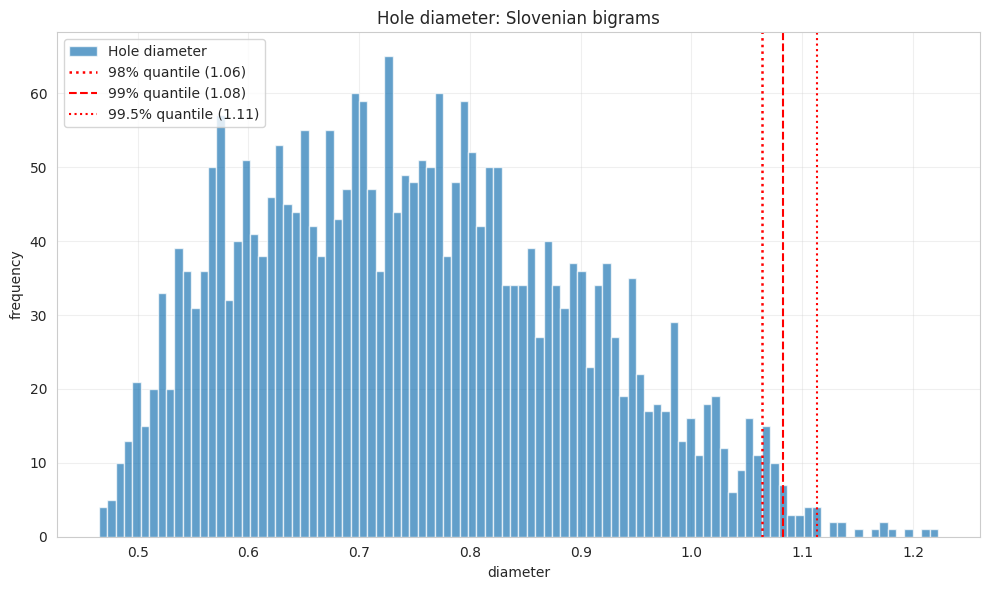

In [ ]:
# Diameters distribution
plt.figure(figsize=(10, 6))

diameters = np.hstack(list(hole_diam.values()))
q98 = np.quantile(diameters, 0.98)
q99 = np.quantile(diameters, 0.99)
q995 = np.quantile(diameters, 0.995)

plt.hist(diameters, bins=100, alpha=0.7, label='Hole diameter')

# Quantile lines
plt.axvline(q98, color='r', linestyle=':', linewidth=1.8, label=f'98% quantile ({q98:.2f})')
plt.axvline(q99, color='r', linestyle='--', linewidth=1.5, label=f'99% quantile ({q99:.2f})')
plt.axvline(q995, color='r', linestyle=':', linewidth=1.5, label=f'99.5% quantile ({q995:.2f})')

plt.xlabel('diameter')
plt.ylabel('frequency')
plt.title('Hole diameter: Slovenian bigrams')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
filtered_by_hole_diam_98 = filter_by_hole_diam(hole_diam, filtered_by_lifetime, q=.98)
np.save("holes/slv_bigram_filtered_by_lifetimes_diam_98.npy", filtered_by_hole_diam_98)
filtered_by_hole_diam_98

{'6b': array([441, 495]),
 '4': array([ 12, 204, 237, 316, 346, 417, 427, 449, 460, 479, 483, 492, 494,
        497]),
 '9b': array([ 86, 202, 245, 248, 253, 289, 320, 390, 472, 495, 496, 499]),
 '1': array([364, 393]),
 '5b': array([169, 187, 213, 413, 431, 470, 472, 488, 494, 497]),
 '7': array([277, 358, 424, 432, 490, 495]),
 '0': array([ 68,  75, 124, 311, 418, 460, 462, 487, 493, 494])}

In [ ]:
sum(len(arr) for arr in filtered_by_hole_diam_98.values())

56

In [ ]:
filtered_by_hole_diam_99 = filter_by_hole_diam(hole_diam, filtered_by_lifetime, q=.99)
np.save("holes/slv_bigram_filtered_by_lifetimes_diam_99.npy", filtered_by_hole_diam_99)
filtered_by_hole_diam_99

{'6b': array([495]),
 '4': array([ 12, 204, 316, 427, 483, 492, 494, 497]),
 '9b': array([ 86, 245, 320, 472, 496]),
 '1': array([393]),
 '5b': array([169, 187, 213, 413, 472, 488, 494]),
 '7': array([424, 490]),
 '0': array([460, 462, 487, 494])}

In [ ]:
sum(len(arr) for arr in filtered_by_hole_diam_99.values())

28

In [ ]:
filtered_by_hole_diam_995 = filter_by_hole_diam(hole_diam, filtered_by_lifetime, q=.995)
np.save("holes/slv_bigram_filtered_by_lifetimes_diam_995.npy", filtered_by_hole_diam_995)
filtered_by_hole_diam_995

{'4': array([316, 427, 483, 492, 494, 497]),
 '9b': array([472]),
 '5b': array([187, 413, 472, 488, 494]),
 '0': array([462, 494])}

In [ ]:
sum(len(arr) for arr in filtered_by_hole_diam_995.values())

14

## Hole contours in words

In [ ]:
word_dictionary = np.load("slv_bigram_norm_dictionary.npy", allow_pickle=True).item()
words = list(word_dictionary.keys())
word_partition = np.load('partition/slv_bigram_partition_norm_new.npy')

In [ ]:
words_on_contour(filtered_by_hole_diam_98, words, word_partition)


Cluster 6b:
********************
Hole 441: ['ohraniti zdravje', 'dušen zdravje', 'dušen bolezen', 'dušen bolečina', 'neizrekljiv bolečina', 'neskončen bolečina', 'tvoj bolečina', 'tvoj bolan', 'tvoj zdrav', 'tvoj dober', 'božji dober', 'kristjan dober', 'zgled dober', 'posnemati dober', 'ohraniti dober']
Hole 495: ['cerkev dober', 'duhoven dober', 'božji dober', 'tvoj dober', 'tvoj pošten', 'tvoj poštenje', 'tvoj čistost', 'tvoj presvet', 'Jezusov presvet', 'bratovščina presvet', 'cerkev presvet', 'cerkev darovati', 'cerkev služiti', 'cerkev skrbeti']

Cluster 4:
********************
Hole 12: ['edin gospodar', 'pravi gospodar', 'pravi gospodinja', 'pravi hčerka', 'pravi prijateljica', 'pravi kavalir', 'pravi vitez', 'pravi junak', 'dober junak', 'dober mladenič', 'dober deklica', 'dober otrok', 'priden otrok', 'rediti otrok', 'delati otrok', 'brez otrok', 'brez gospodinja', 'noben gospodar', 'brez gospodar']
Hole 204: ['storiti bati', 'storiti meniti', 'storiti drag', 'pomisliti drag'

In [ ]:
words_on_contour(filtered_by_hole_diam_99, words, word_partition)


Cluster 6b:
********************
Hole 495: ['cerkev dober', 'duhoven dober', 'božji dober', 'tvoj dober', 'tvoj pošten', 'tvoj poštenje', 'tvoj čistost', 'tvoj presvet', 'Jezusov presvet', 'bratovščina presvet', 'cerkev presvet', 'cerkev darovati', 'cerkev služiti', 'cerkev skrbeti']

Cluster 4:
********************
Hole 12: ['edin gospodar', 'pravi gospodar', 'pravi gospodinja', 'pravi hčerka', 'pravi prijateljica', 'pravi kavalir', 'pravi vitez', 'pravi junak', 'dober junak', 'dober mladenič', 'dober deklica', 'dober otrok', 'priden otrok', 'rediti otrok', 'delati otrok', 'brez otrok', 'brez gospodinja', 'noben gospodar', 'brez gospodar']
Hole 204: ['storiti bati', 'storiti meniti', 'storiti drag', 'pomisliti drag', 'videti drag', 'videti srečen', 'videti nesrečen', 'videti strašen', 'slišati strašen', 'zgoditi strašen', 'zgoditi nesreča', 'zgoditi krivica', 'storiti kriv', 'storiti krivica']
Hole 316: ['imeti jezik', 'imeti govor', 'imeti beseda', 'dobiti beseda', 'vzeti beseda', '

In [ ]:
words_on_contour(filtered_by_hole_diam_995, words, word_partition)


Cluster 4:
********************
Hole 316: ['imeti jezik', 'imeti govor', 'imeti beseda', 'dobiti beseda', 'vzeti beseda', 'izpustiti beseda', 'pretrgati beseda', 'izpregovoriti beseda', 'spregovoriti beseda', 'reči beseda', 'reči naglas', 'reči polglasno', 'reči smehljaje', 'reči gospodična', 'reči gospa', 'dejati gospa', 'oditi gospa', 'priti gospa', 'priti baron', 'priti grof', 'priti vojvoda', 'priti cesar', 'poslati cesar', 'dobiti cesar', 'imeti cesar', 'imeti francoski', 'imeti nemški']
Hole 427: ['delati strah', 'delati hrup', 'brez hrup', 'brez godrnjanje', 'brez glas', 'brez beseda', 'prazen beseda', 'črhniti beseda', 'ziniti beseda', 'reči beseda', 'reči besedica', 'reči osorno', 'reči stric', 'reči doma', 'misliti doma', 'goditi doma', 'delati doma', 'delati zvečer', 'delati mrak', 'delati tema']
Hole 483: ['postati sovražnik', 'postati vojak', 'postati general', 'postati opat', 'postati župnik', 'postati doktor', 'postati gospod', 'spoznati gospod', 'čuditi gospod', 'videt